# Machine learning for medicine
## Linear Regression 1: Finding lines that explain our data

## Overview
Linear regression is a fancy way of saying: let's find the line that relates variables.

The real power of linear regression is clear when we've got way, way more than just two variables.
In this notebook we'll start with a brief intro of linear regression with two variables, then show how it can work with many more, and finally demonstrate the power of machine learning in messy data.

As always, there's code and interactive widgets all along the way.

Salt and blood pressure ->
Diabetes and lifetime CV risk ->


### Code Setup

In [ ]:
# The big library for doing math + data in python
import numpy as np

# A big library that has a lot of useful functions for scientific use of python
import scipy

# The main library for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
matplotlib.rcParams['figure.figsize'] = [15, 10]

# The main library used for statistics
import scipy.stats as stats

# The library we're going to use for our linear regression
from sklearn.linear_model import LinearRegression

# Libraries that let us use interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Misc stuff related to cleaning up code and displaying results in a pretty way
from IPython.display import Markdown as md


#### General Functions
def gen_lin_data(factor,noise,samples):
    x = np.random.uniform(-10,10,size=(samples,))
    y = factor * x + np.random.normal(0,noise,size=x.shape)
    
    return x,y

def simple_eg(slope=1.0,noise=0.0,samples=100):
    x,y = gen_lin_data(slope,noise,samples)
    #x = np.random.uniform(-10,10,size=(samples,))
    #y = slope * x + np.random.normal(0,noise,size=x.shape)
    
    plt.figure()
    plt.scatter(x,y)
    plt.scatter(x,np.random.normal(0,noise,size=x.shape),color='red',alpha=0.4)
    plt.ylim(-10,10)
    plt.xlim(-10,10)
    plt.axis('off')
    
    plt.legend(['Correlated','Uncorrelated'])
    corr_val = stats.pearsonr(x,y)
    plt.text(2,-10,s='Pearson: ' + str(corr_val[0]) + '\n p=' + str(corr_val[1]))
    plt.show()

## Linear Regression (simple)
Let's say we're trying to see whether there's a relationship between a patient's A1c and their blood glucose.

In [ ]:
# the ground truth
a1c_b = np.linspace(0,20,1)

First, for this exercise, we defined the *truth*: that the blood glucose is just the A1c times a *conversion factor* which is $\frac{100}{6} \approx 16.6667$

In [ ]:
# Let's define *the truth* so that we can compare our data-driven analysis to something concrete
conversion_factor = (1/6) * 100
truth = lambda x: conversion_factor * x

Next, we're going to *simulate* a study with a certain number of patients.

In [ ]:
num_pts = 10
# The data we (simulated) collected from paWtients
exp_1_a1c = np.random.uniform(0,15,size=(num_pts,1))
exp_1_bgluc = truth(exp_1_a1c) + np.random.normal(0,20,size=(num_pts,1))

Let's see what the data from the experiment looks like:

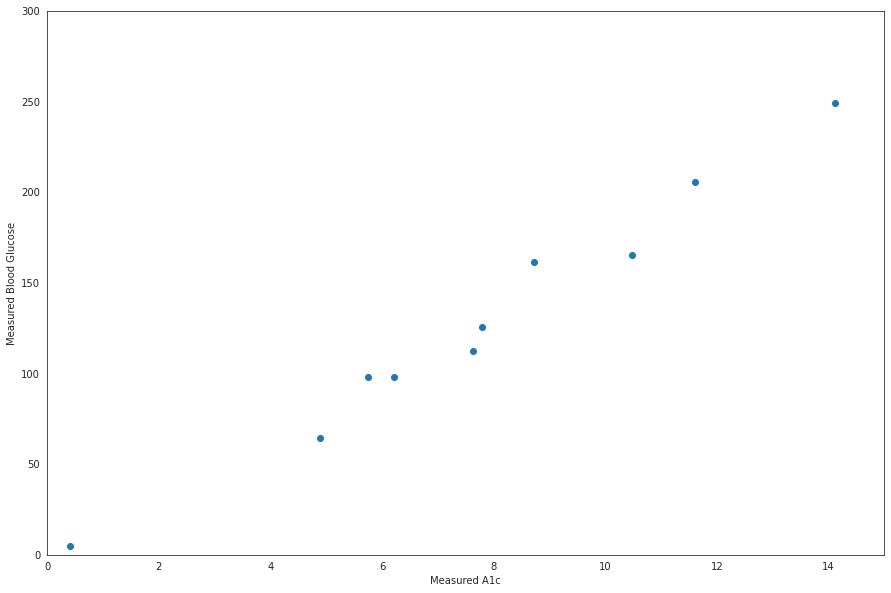

In [95]:
def plot_data(a1c,bgluc):
    plt.figure()
    plt.scatter(a1c,bgluc)
    plt.xlabel('Measured A1c')
    plt.ylabel('Measured Blood Glucose')
    plt.xlim((0,15))
    plt.ylim((0,300));
    
plot_data(exp_1_a1c,exp_1_bgluc)

In [96]:
x = exp_1_a1c.reshape(-1,1)
y = exp_1_bgluc.reshape(-1,1)
reg = LinearRegression(fit_intercept=True).fit(x, y)
reg.score(x, y)

slope_estimate = reg.coef_[0,0]
print('Regression slope is ' + str(slope_estimate))
#reg.intercept_

Regression slope is 18.16262244892617


How close are we to the true slope16.666666666666664 ?

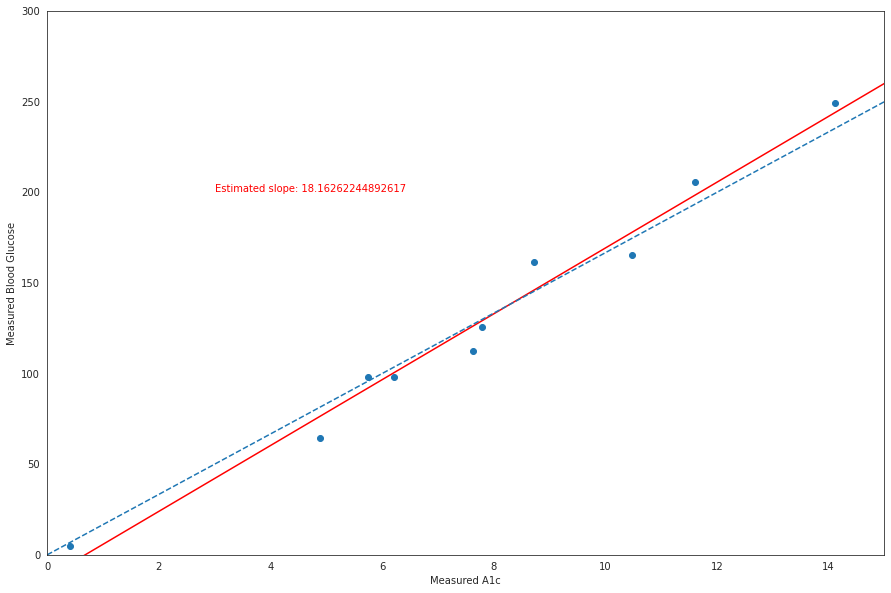

In [97]:
plot_data(exp_1_a1c,exp_1_bgluc)

#Now let's plot the lines that we think link our variables
x_fix = np.linspace(0,15,100)
plt.plot(x_fix,slope_estimate * x_fix + reg.intercept_,'red')
plt.text(3,200,'Estimated slope: ' + str(slope_estimate),color='red')
plt.plot(x_fix,truth(x_fix),'--')

md("How close are we to the true slope" + str(conversion_factor) + " ?")

The goal in any linear regression is to *figure out* what the true conversion-factor is using the *data*.

What we did here was take data from our (simulated) patients and fit a line between the datapoints to see if we could *infer* the true relationship between A1c and blood glucose. 
Turns out we can!
Even if it's not perfect, the linear regression approach let us see that there's an *association* between the two variable.


## Linear Regression with Outliers
What happens when there are datapoints in our data that break our assumption that we're studying one, and only one, thing?
This is where we start seeing ML really start to shine.

Outliers are one place where it becomes important to be careful and transparent about what leads you to *ignore* datapoints.
If you're doing it visually and manually, no matter how good your intentions, it's hard not to be biased.
It's hard not to ignore datapoints that are convenient to ignore.

ML relies on algorithms (fancy word for math) to analyse data.
This enables a whole new level of transparency: we can see exactly what went into analysing the data and if there are any details missing.


### Outliers
Let's start with the same 2-variable example we had above but add an outlier datapoint.

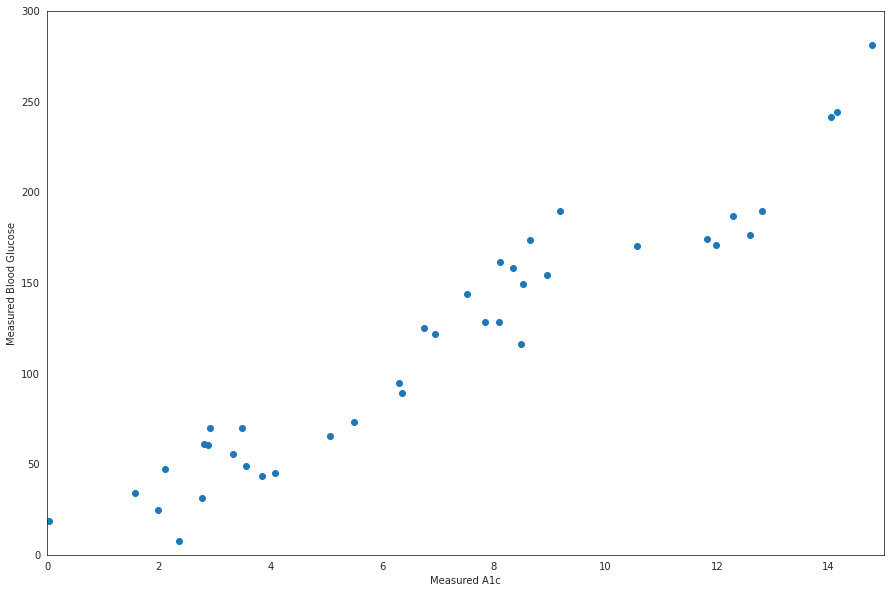

In [98]:
# The data we (simulated) collected from patients
num_pts = 40
exp_2_a1c = np.random.uniform(0,15,size=(num_pts,1))
exp_2_bgluc = truth(exp_2_a1c) + np.random.normal(0,20,size=(num_pts,1))

plot_data(exp_2_a1c,exp_2_bgluc)

Plus one patient that we collected with measurements that look really, really weird...

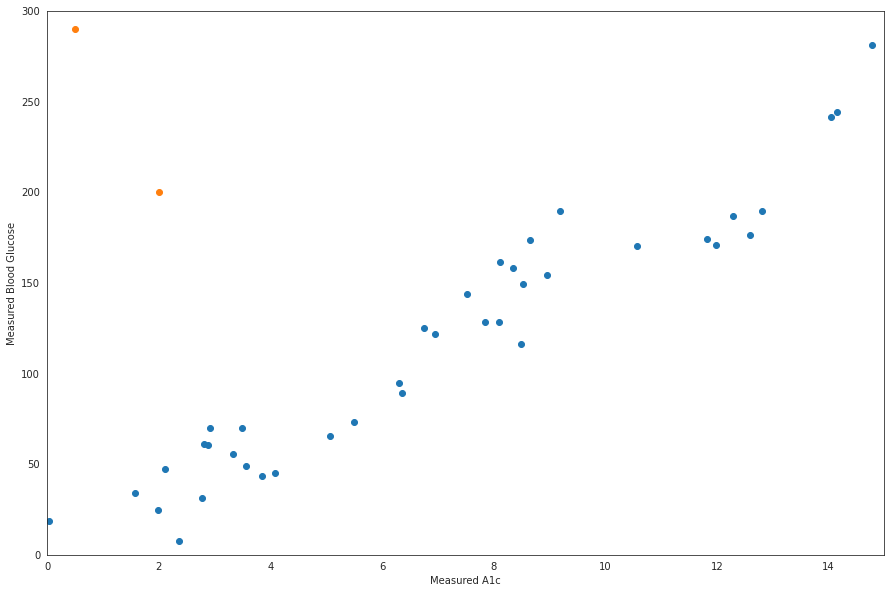

In [99]:
plot_data(exp_2_a1c,exp_2_bgluc)

ol_a1c = np.array([2,0.5]).reshape(-1,1)
ol_bgluc = np.array([200,290]).reshape(-1,1)

plt.scatter(ol_a1c,ol_bgluc);

Let's do our standard linear regression on this dataset

In [100]:
full_exp_2_a1c = np.vstack((exp_2_a1c,ol_a1c))
full_exp_2_bgluc = np.vstack((exp_2_bgluc,ol_bgluc))

#Just reshape the data so we can analyse it
x = full_exp_2_a1c.reshape(-1,1)
y = full_exp_2_bgluc.reshape(-1,1)

# Now we're going to tell Python to make our linear model
reg = LinearRegression(fit_intercept=True).fit(x, y)
reg.score(x, y) #This gives us a 'score' that tells us how well the model did

slope_estimate = reg.coef_[0,0]
print('Regression slope is ' + str(slope_estimate))

Regression slope is 13.204459798484454


In [101]:
x = exp_2_a1c.reshape(-1,1)
y = exp_2_bgluc.reshape(-1,1)
reg_nol = LinearRegression(fit_intercept=True).fit(x, y)
reg_nol.score(x, y)

0.9223440604088056

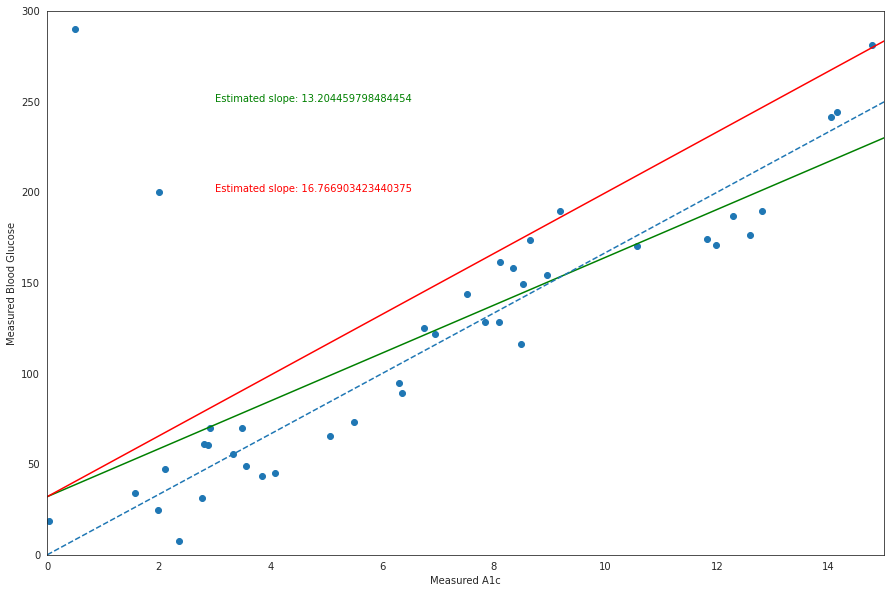

In [102]:
plot_data(full_exp_2_a1c,full_exp_2_bgluc)

#Now let's plot the lines that we think link our variables
x_fix = np.linspace(0,15,100)
plt.plot(x_fix,reg.coef_[0,0] * x_fix + reg.intercept_,'green')
plt.text(3,250,'Estimated slope: ' + str(reg.coef_[0,0]),color='green')
plt.plot(x_fix,reg_nol.coef_[0,0] * x_fix + reg.intercept_,'red')
plt.text(3,200,'Estimated slope: ' + str(reg_nol.coef_[0,0]),color='red')
plt.plot(x_fix,truth(x_fix),'--');

The true model is depicted by the dotted blue line.
This is the model that we *defined* way up in [the first section]().

The linear regression model that *ignored the outliers* is depicted by the red line.
The linear regression model *with outliers* is depicted by the green line.
We can see how far the green line is from the *true* line and the *red* model.

Our goal next is to let the *algorithm* come up with the red line without explicitly telling it to ignore the two outlier points.

### Robust Regression

How do we "see through" the outliers?
In the before-days, we might say that those two points look like outliers and/or we had reason to suspect the lab had issues on those days so it's reasonable for us to *ignore* those two datapoints in our analysis.
This can be done responsibly, but let's leverage math to achieve the same goal in a much more trustworthy way.

Some types of regression are called *robust* if they can find the true association even in the presence of outliers like the two troublemakers we see here.

Let's use [RANSAC]() which takes a subset of the data to make a model, and does this 100 times to calculate the model that makes "the most sense", even with the outliers present.

### Three-dimensional regression

Let's end on a cool, interactive note.
We're going to integrate everything from the above sections into a single example that *starts* to show where linear regression becomes incredibly helpful for medicine.
We're going to look at a dataset involving *three* variables instead of just two variables.

The variables we're going to look at are related this way:

$ y = 0.2 \cdot x + 10 \cdot w$

If we were doing the standard approach, we'd focus on x (independent variable) and y (dependent variable) while keeping w constant.


In [138]:
from mpl_toolkits import mplot3d
import pandas
from pandas import DataFrame
import plotly.express as px

model = np.array([0.2,2]).reshape(-1,1)

noise_slider = widgets.FloatSlider(min=0.0,max=10.0,description="Noise")
display(noise_slider)


FloatSlider(value=0.0, description='Noise', max=10.0)

In [139]:
def run_3d(noise):
  pt_num = 100
  x = np.random.uniform(-10,10,size=(pt_num,2))
  y = np.dot(x,model)
  y += np.random.normal(0,noise,size=y.shape)
  data = np.hstack((x,y))
  dats = {'x':data[:,0].squeeze(),'w':data[:,1].squeeze(),'y':data[:,2].squeeze()}
  df = DataFrame(data=dats)

  fig = px.scatter_3d(df, x='x', y='w', z='y',width=1200, height=1200)
  view_range=[-10,10]
  fig.update_layout(scene=dict(xaxis=dict(range=view_range),yaxis=dict(range=view_range),zaxis=dict(range=view_range),aspectmode="cube"))
  fig['layout'].update(width=700, height=700, autosize=False)
  fig.show()

  model_3d = LinearRegression(fit_intercept=True).fit(x, y)
  model_3d.score(x, y) #This gives us a 'score' that tells us how well the model did

  return model_3d.coef_

model_estimate = run_3d(noise=noise_slider.value)
print('Estimated slope is ' + str(model_estimate))

Estimated slope is [[0.27487123 1.93112438]]
